In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

import tensorflow as tf
from keras.utils import to_categorical

## Functions

### Model Training

In [40]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()
    
    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()
    
    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

## Read data

In [2]:
df = pd.read_csv('data/final_data/balanced_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41326 entries, 0 to 41325
Columns: 112 entries, TransactionID to isFraud
dtypes: float64(105), int64(7)
memory usage: 35.3 MB


In [3]:
df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,isFraud
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


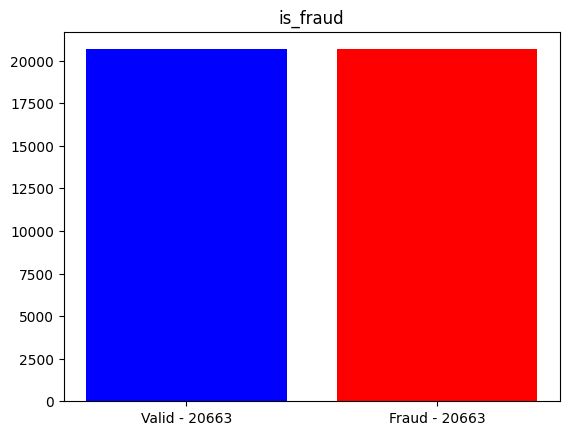

In [4]:
plt.rcdefaults()
# obtain ground truth from train column
is_fraud = df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('is_fraud')
plt.savefig('graphs/train_barplot.png')
plt.show()

## Divide the data into training, validation and test data and prepare for model training

### Divide data into train_df and test_df

In [25]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()


counter = 0

for label in df['isFraud'].unique():
    label_data = df[df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    
    split_index = int(0.8 * len(label_data))
    if counter != 0:
        train_df = pd.concat([train_df, label_data[:split_index]])
        test_df = pd.concat([test_df, label_data[split_index:]])
    else:
        train_df = label_data[:split_index]
        test_df = label_data[split_index:]
        
    counter += 1
    
print(f'len(train_df) = {len(train_df)}')
print(f'len(test_df) = {len(test_df)}')

len(train_df) = 33060
len(test_df) = 8266


#### View the distribution of classes in train and test data

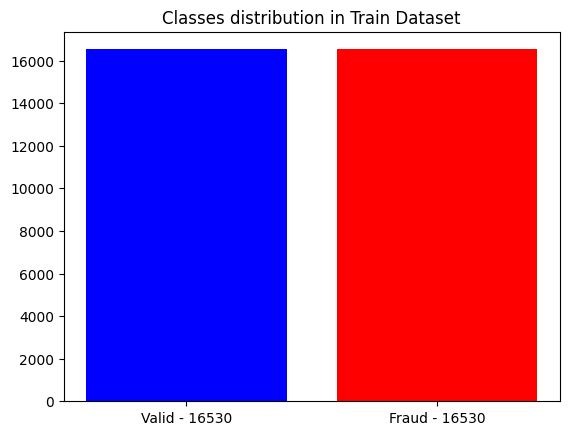

In [6]:
plt.rcdefaults()
# obtain ground truth from train column
is_fraud = train_df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('Classes distribution in Train Dataset')
plt.savefig('graphs/train_barplot.png')
plt.show()

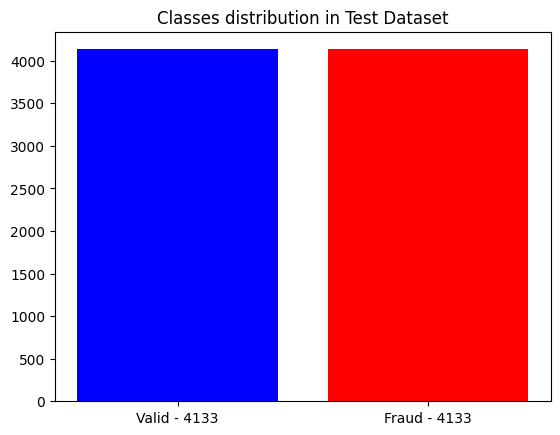

In [7]:
# obtain ground truth from train column
is_fraud = test_df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('Classes distribution in Test Dataset')
plt.savefig('graphs/test_barplot.png')
plt.show()

### Divide train_df into X_train, y_train, X_valid, y_valid

In [26]:
X_train = pd.DataFrame()
y_train = []

X_valid = pd.DataFrame()
y_valid = []

counter = 0

for label in train_df['isFraud'].unique():
    label_data = train_df[train_df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    split_index = int(0.8 * len(label_data))
    
    if counter != 0:
        X_train = pd.concat([X_train, label_data[label_data.columns[:-1]][:split_index]])
        X_valid = pd.concat([X_valid, label_data[label_data.columns[:-1]][split_index:]])
    else:
        X_train = label_data[label_data.columns[:-1]][:split_index]
        X_valid = label_data[label_data.columns[:-1]][split_index:]
        
    y_train.extend(list(label_data['isFraud'].values[:split_index]))
    y_valid.extend(list(label_data['isFraud'].values[split_index:]))
    counter += 1
    
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

len(X_train) = 26448
len(y_train) = 26448
len(X_valid) = 6612
len(y_valid) = 6612


### Divide test_df into X_test and y_test

In [27]:
X_test = test_df[test_df.columns[:-1]]
y_test = test_df['isFraud'].values
len(X_test)

8266

### View the distribution of classes in train, validation and test data

In [10]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'\nlen(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'\nlen(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 26448
len(y_train) = 26448

len(X_valid) = 6612
len(y_valid) = 6612

len(X_test) = 8266
len(y_test) = 8266


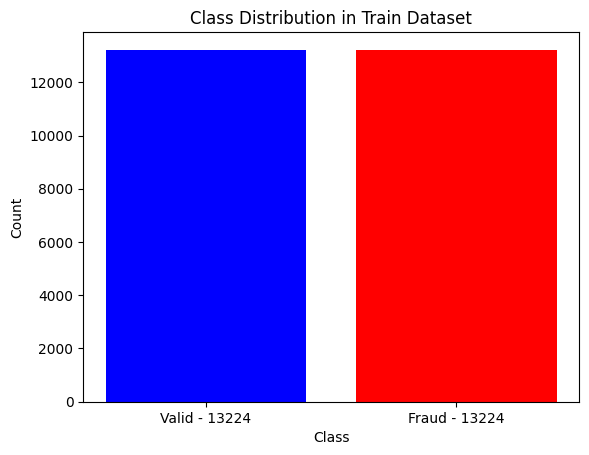

In [11]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_train) == 0)
num_fraud_train = len(y_train) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Train Dataset')
plt.savefig('graphs/train_barplot.png')
plt.show()

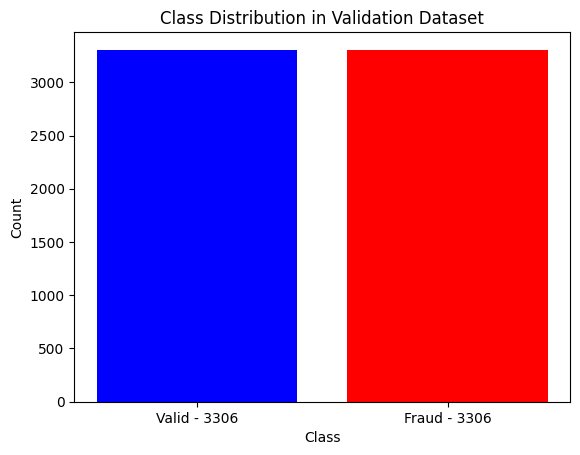

In [12]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_valid) == 0)
num_fraud_train = len(y_valid) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Validation Dataset')
plt.savefig('graphs/validation_barplot.png')
plt.show()

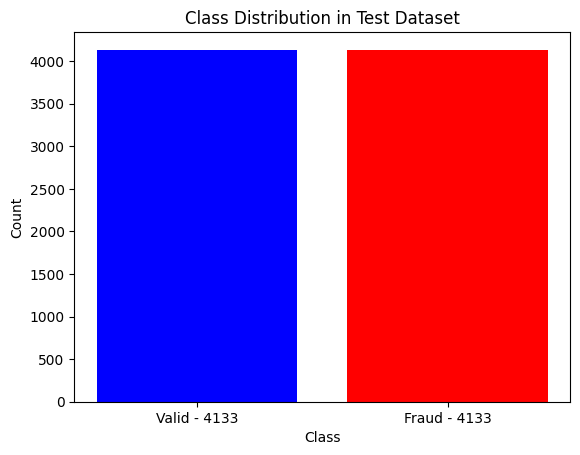

In [13]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_test) == 0)
num_fraud_train = len(y_test) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Dataset')
plt.savefig('graphs/test_barplot.png')
plt.show()

### Scale X_train, X_valid, X_test datasets

In [28]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Prepare target vectors

In [29]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

## Test model training

In [30]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 26448
len(y_train) = 26448
len(X_valid) = 6612
len(y_valid) = 6612
len(X_test) = 8266
len(y_test) = 8266


In [33]:
best_model = None
best_model_accuracy = None
best_model_history = None

experiments_number = 3

accuracy_list = []

for i in range(experiments_number):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(len(X_train.columns), )))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, validation_data=(X_valid_scaled, y_valid))
          
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test_scaled, y_test)
        
    accuracy_list.append(accuracy)
    print(f'Accuracy: {accuracy*100:.3f}')
    
    if best_model == None:
        best_model = model
        best_model_accuracy = accuracy
        best_model_history = history
        continue
        
    if accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = model
        best_model_history = history
        print(f'best_model_accuracy: {accuracy*100:.3f}')
        
print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')

Epoch 1/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4730 - accuracy: 0.7771 - val_loss: 1.0216 - val_accuracy: 0.5891
Epoch 2/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4309 - accuracy: 0.8002 - val_loss: 1.3658 - val_accuracy: 0.5632
Epoch 3/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4226 - accuracy: 0.8072 - val_loss: 1.4234 - val_accuracy: 0.5842
Epoch 4/10
2645/2645 [==============================] - 5s 2ms/step - loss: 0.4157 - accuracy: 0.8114 - val_loss: 1.3401 - val_accuracy: 0.6165
Epoch 5/10
2645/2645 [==============================] - 4s 2ms/step - loss: 0.4090 - accuracy: 0.8125 - val_loss: 2.2043 - val_accuracy: 0.5555
Epoch 6/10
2645/2645 [==============================] - 4s 2ms/step - loss: 0.4073 - accuracy: 0.8158 - val_loss: 2.2641 - val_accuracy: 0.5697
Epoch 7/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4068 - accuracy: 0.8174 - val_loss: 2.0855 - val_accuracy:

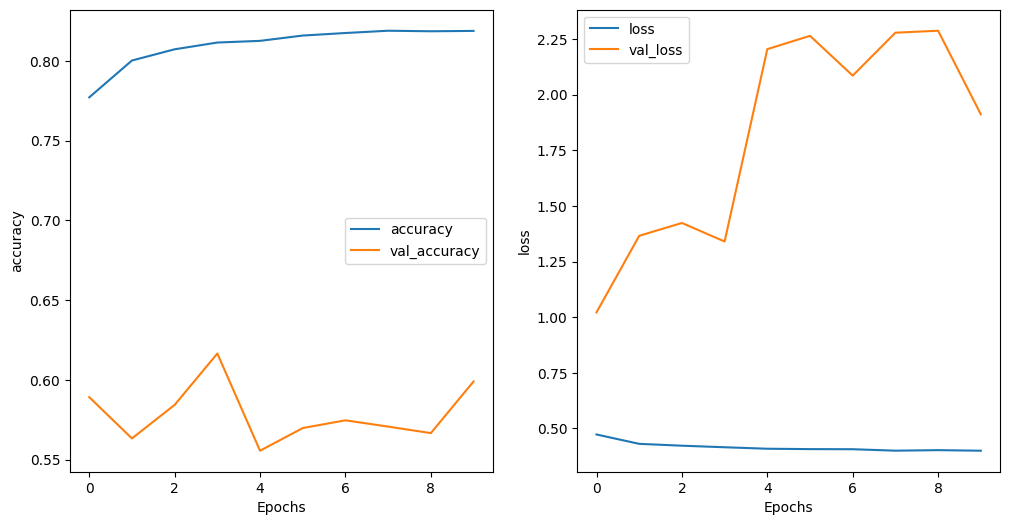

In [41]:
plot_graphs(history=best_model_history, strings=['accuracy', 'loss'], filename='graphs/accuracy_loss')

## Use RFE to assess the informativeness of inputs

In [ ]:
# Create a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an RFE model
rfe = RFE(estimator=rf_model, n_features_to_select=1)

# Fit RFE model on your data
rfe.fit(X_train_scaled, y_train)

# Get feature rankings from RFE
feature_rankings = rfe.ranking_

# Get feature names
feature_names = X_train.columns

# Sort features by rankings
sorted_indices = np.argsort(feature_rankings)
sorted_feature_names = feature_names[sorted_indices]

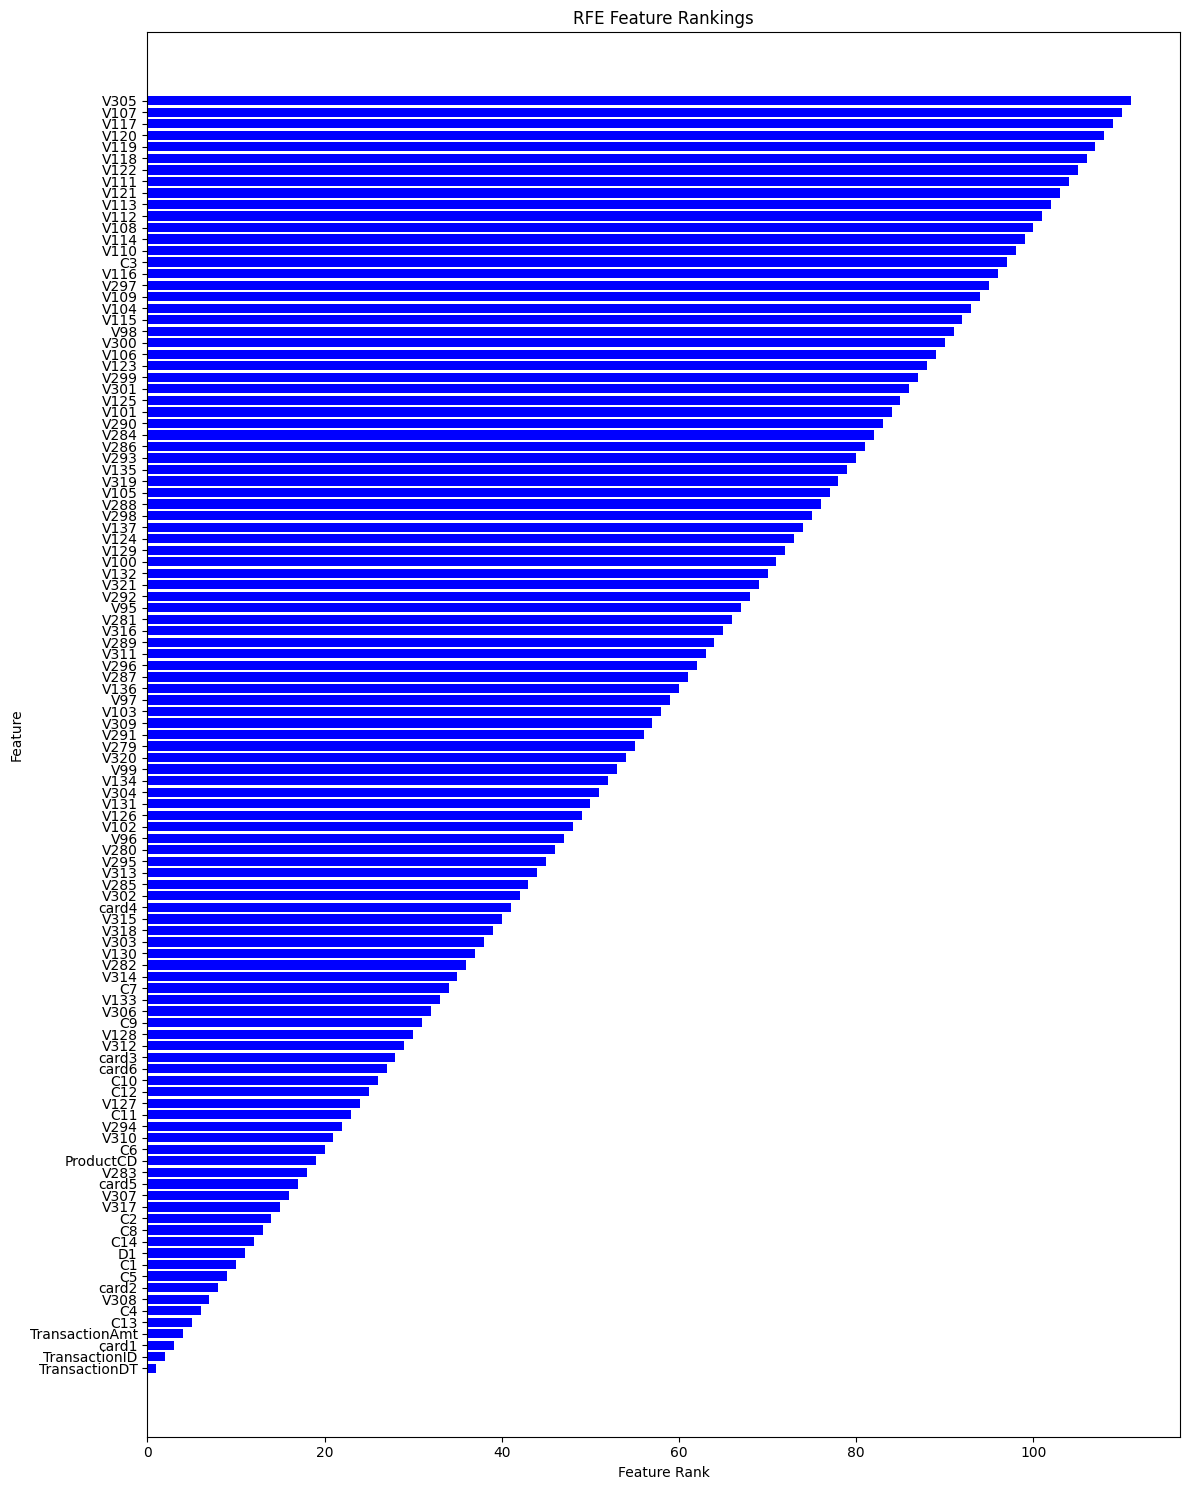

In [38]:
# Create a bar plot for RFE feature rankings
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), feature_rankings[sorted_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Rank')
plt.ylabel('Feature')
plt.title('RFE Feature Rankings')
plt.tight_layout()

plt.savefig('graphs/rfe_feature_rankings.png')
plt.show()

## Use compactness theory to determine the most important weights

### Find the optimal number of neurons for a single-layer perceptron 

In [78]:
best_model = None
best_model_accuracy = None
best_model_history = None

experiments_number = 5

for neurons in range(1, 11):
    print(f"\nNumber of neurons: {neurons}")
    accuracy_list = []
    for i in range(experiments_number):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(neurons, input_dim=X_train_scaled.shape[1], activation='sigmoid')
        ])
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

        # Train the model on a sample containing samples of both classes
        perceptron_history = model.fit(X_train_scaled, y_train, verbose=0, epochs=10, batch_size=64, validation_data=(X_valid_scaled, y_valid))

        # evaluate the keras model
        _, accuracy = model.evaluate(X_test_scaled, y_test)

        accuracy_list.append(accuracy)
        print(f'{i+1}) Accuracy: {accuracy*100:.3f}')

        if best_model == None:
            best_model = model
            best_model_accuracy = accuracy
            best_model_history = history
            continue

        if accuracy > best_model_accuracy:
            best_model_accuracy = accuracy
            best_model = model
            best_model_history = history
            print(f'best_model_accuracy: {accuracy*100:.3f}')

    print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')


Number of neurons: 1
259/259 [==============================] - 0s 1ms/step - loss: 0.2748 - accuracy: 0.5661
1) Accuracy: 56.605
259/259 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.5653
2) Accuracy: 56.533
259/259 [==============================] - 0s 1ms/step - loss: 0.2774 - accuracy: 0.5632
3) Accuracy: 56.315
259/259 [==============================] - 0s 1ms/step - loss: 0.2735 - accuracy: 0.5694
4) Accuracy: 56.944
best_model_accuracy: 56.944
259/259 [==============================] - 0s 1ms/step - loss: 0.2794 - accuracy: 0.5575
5) Accuracy: 55.746

Average accuracy = 56.429

Number of neurons: 2
259/259 [==============================] - 0s 1ms/step - loss: 0.2778 - accuracy: 0.5853
1) Accuracy: 58.529
best_model_accuracy: 58.529
259/259 [==============================] - 0s 1ms/step - loss: 0.2755 - accuracy: 0.3998
2) Accuracy: 39.983
259/259 [==============================] - 0s 1ms/step - loss: 0.2777 - accuracy: 0.3213
3) Accuracy: 32.132
2

### Use the compactness theory algorithm

In [45]:
identity_matrix = np.identity(X_train_scaled.shape[1])
offset = np.zeros((1, X_train_scaled.shape[1]))
input_matrix = np.vstack([identity_matrix, offset])
print(f"input_matrix:\n {input_matrix}")

input_matrix:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [72]:
# Step 1: Train a single-layer linear perceptron
# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_data=(X_valid_scaled, y_valid))

# Step 2: Apply the identity (square) matrix with a zero row
identity_matrix = np.identity(X_train_scaled.shape[1])
offset = np.zeros((1, X_train_scaled.shape[1]))
input_matrix = np.vstack([identity_matrix, offset])

# Step 3: Calculate the feedback for each row minus the offset
feedback = model.predict(input_matrix)
feedback_minus_offset = feedback - model.predict(offset)  # Subtract the offset term

# Step 4: Evaluate the weight of inputs in absolute terms
weights = np.abs(feedback_minus_offset)

Epoch 1/10
414/414 [==============================] - 1s 2ms/step - loss: 0.2279 - accuracy: 0.6359 - val_loss: 0.2372 - val_accuracy: 0.6214
Epoch 2/10
414/414 [==============================] - 1s 1ms/step - loss: 0.1954 - accuracy: 0.7177 - val_loss: 0.2415 - val_accuracy: 0.6213
Epoch 3/10
414/414 [==============================] - 1s 1ms/step - loss: 0.1888 - accuracy: 0.7265 - val_loss: 0.2429 - val_accuracy: 0.6145
Epoch 4/10
414/414 [==============================] - 1s 1ms/step - loss: 0.1857 - accuracy: 0.7319 - val_loss: 0.2428 - val_accuracy: 0.6136
Epoch 5/10
414/414 [==============================] - 1s 1ms/step - loss: 0.1837 - accuracy: 0.7333 - val_loss: 0.2419 - val_accuracy: 0.6174
Epoch 6/10
414/414 [==============================] - 1s 1ms/step - loss: 0.1821 - accuracy: 0.7348 - val_loss: 0.2409 - val_accuracy: 0.6284
Epoch 7/10
414/414 [==============================] - 1s 1ms/step - loss: 0.1808 - accuracy: 0.7363 - val_loss: 0.2395 - val_accuracy: 0.6299
Epoch 

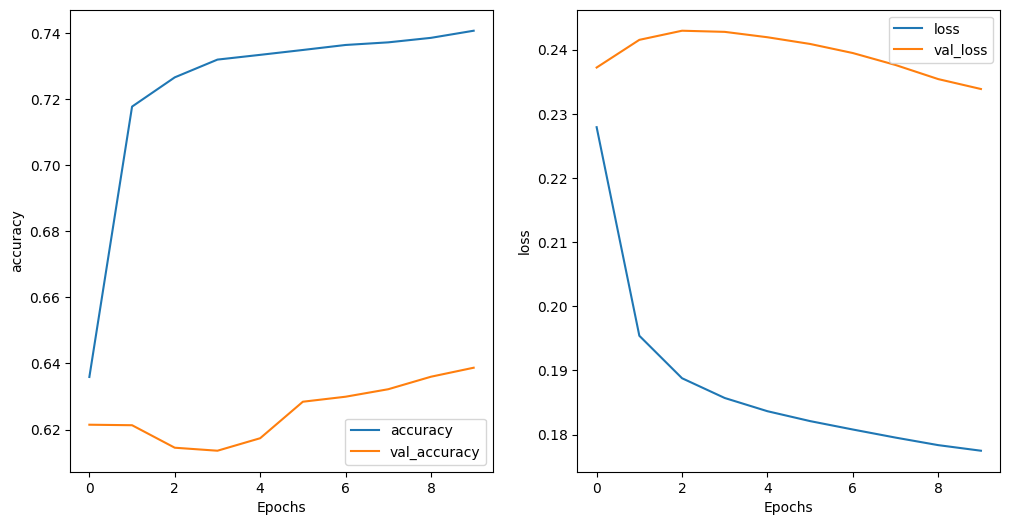

In [73]:
plot_graphs(history=perceptron_history, strings=['accuracy', 'loss'], filename=None)

In [74]:
weights[0]

array([0.07872412], dtype=float32)

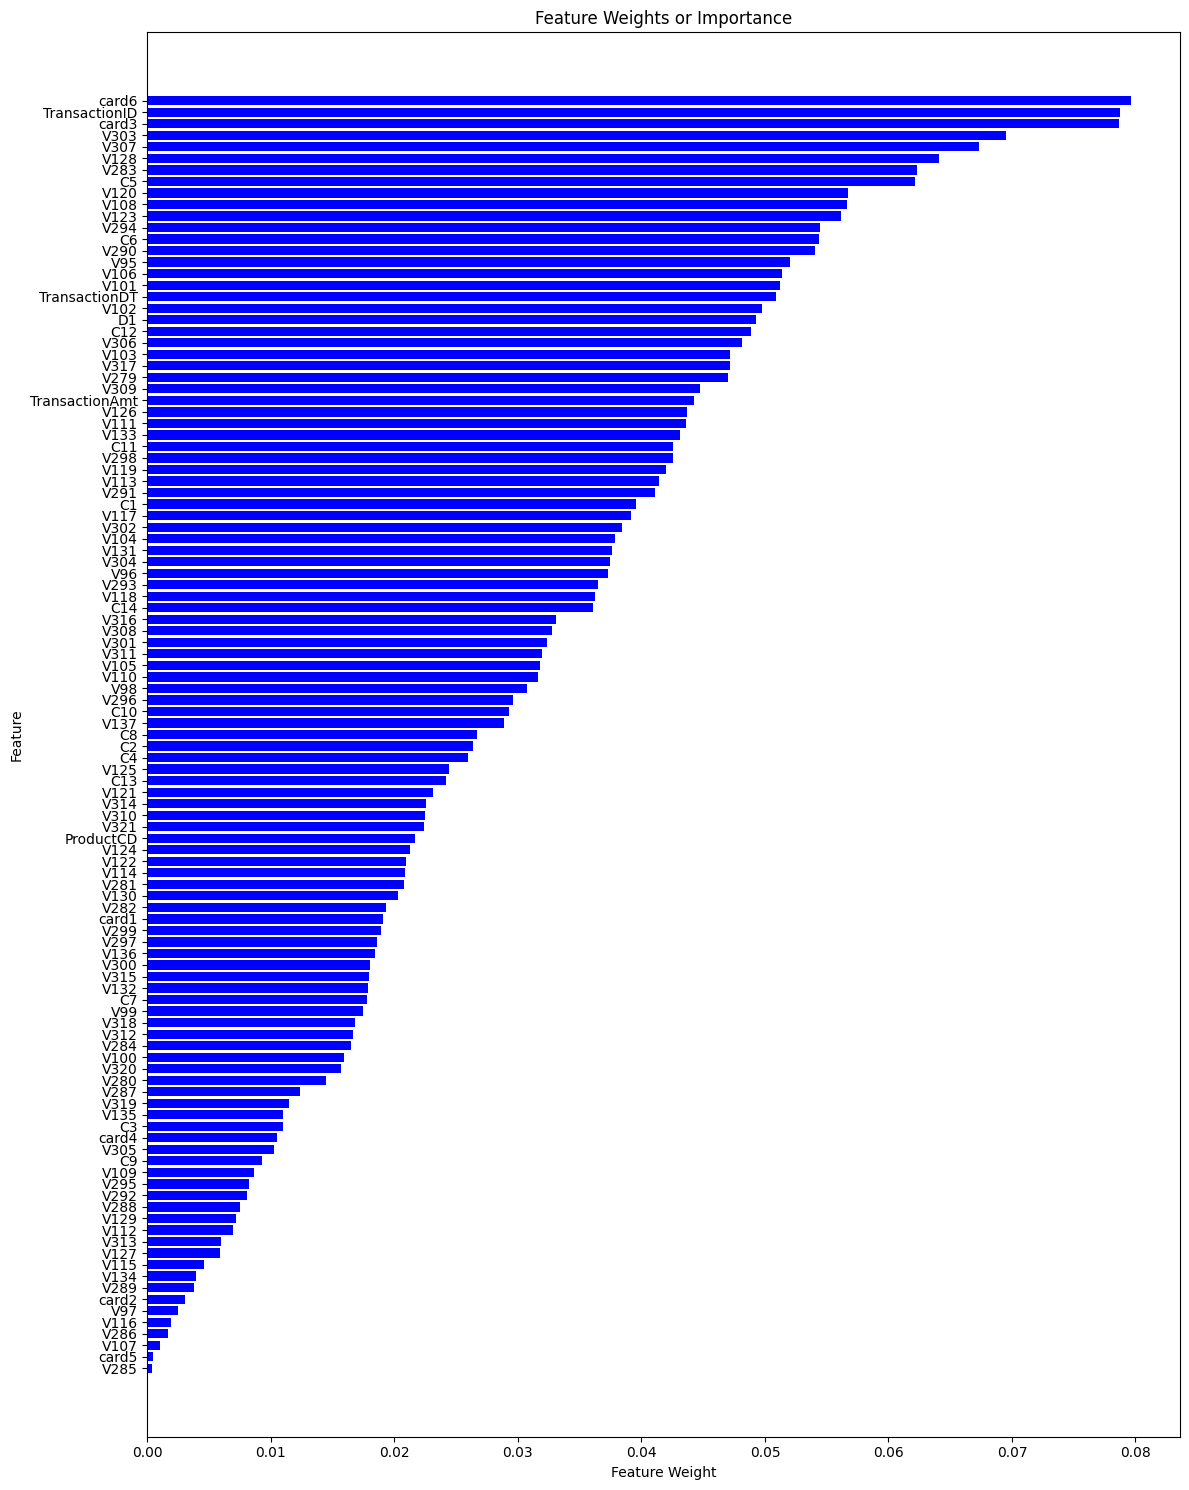

In [75]:
# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights[:-1].squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/feature_weights.png')
plt.show()